# Qualitative Analysis - How consistent are their (Agentic-PRs) descriptions with the actual code changes?

In [16]:
!pip install sentence-transformers

In [17]:
from sentence_transformers import SentenceTransformer, util
import re

In [18]:
# Initialize the model
model = SentenceTransformer('all-MiniLM-L6-v2')

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

In [28]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
import seaborn as sns


In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
df_pr_commit_details = pd.read_parquet('/content/drive/MyDrive/Research/AIDev/pr_commit_details.parquet')

# Now you can use df_pr_commit_details in notebook Y
df_pr_commit_details.head(3)

print('shape of pr_commit_details: ',df_pr_commit_details.shape)
print("Columns of pr_commit_details: ", list(df_pr_commit_details.columns))

shape of pr_commit_details:  (711923, 14)
Columns of pr_commit_details:  ['sha', 'pr_id', 'author', 'committer', 'message', 'commit_stats_total', 'commit_stats_additions', 'commit_stats_deletions', 'filename', 'status', 'additions', 'deletions', 'changes', 'patch']


In [4]:
merged_df = pd.read_parquet('/content/drive/MyDrive/Research/AIDev/merged_data.parquet')

# 3. Now you can use merged_df in notebook Y
merged_df.head()
print('Shape of merged_df:', merged_df.shape)

Shape of merged_df: (33580, 10)


In [5]:
# Create code change summary for each PR
def generate_code_summary(pr_id):
    """Generate a textual summary of code changes for a PR"""
    files_df = df_pr_commit_details[df_pr_commit_details['pr_id'] == pr_id]
    if files_df.empty:
        return ""

    summary_parts = []
    for _, row in files_df.iterrows():
        summary_parts.append(
            f"{row['status']} file {row['filename']} with {row['additions']} additions and {row['deletions']} deletions"
        )
    return ". ".join(summary_parts)

In [6]:
print(f"Generating code summaries for ALL {len(merged_df)} PRs...")
merged_df['code_summary'] = merged_df['pr_id'].apply(generate_code_summary)

Generating code summaries for ALL 33580 PRs...


In [13]:
with pd.option_context('display.max_colwidth', None):
    print(merged_df['code_summary'].head(2).to_string())


0    modified file .github/workflows/python-testing.yml with 12.0 additions and 0.0 deletions. modified file agentops/__init__.py with 35.0 additions and 0.0 deletions. modified file agentops/llms/providers/ai21.py with 15.0 additions and 61.0 deletions. modified file agentops/llms/providers/groq.py with 7.0 additions and 1.0 deletions. modified file agentops/llms/providers/litellm.py with 31.0 additions and 7.0 deletions. modified file agentops/llms/providers/mistral.py with 24.0 additions and 26.0 deletions. added file tests/ai21_handlers/test_ai21_integration.py with 82.0 additions and 0.0 deletions. added file tests/anthropic_handlers/test_anthropic_integration.py with 75.0 additions and 0.0 deletions. added file tests/cohere_handlers/test_cohere_integration.py with 83.0 additions and 0.0 deletions. added file tests/groq_handlers/test_groq_integration.py with 73.0 additions and 0.0 deletions. added file tests/litellm_handlers/test_litellm_integration.py with 73.0 additions and 0.0 

In [19]:
# Calculate similarity between description and code changes
def calculate_similarity(desc, code_desc):
    if not desc or not code_desc:
        return np.nan
    desc_embedding = model.encode(desc)
    code_embedding = model.encode(code_desc)
    similarity = util.cos_sim(desc_embedding, code_embedding).item()
    return similarity

print("Calculating semantic similarity...")
merged_df['description_similarity'] = merged_df.apply(
    lambda row: calculate_similarity(row['full_description'], row['code_summary']), axis=1
)

Calculating semantic similarity...


In [20]:
# Remove rows with NaN similarity
similarity_df = merged_df.dropna(subset=['description_similarity'])

# Analyze similarity results
similarity_stats = similarity_df['description_similarity'].describe()
print("\nDescription-Code Similarity Statistics:")
print(similarity_stats)


Description-Code Similarity Statistics:
count    33580.000000
mean         0.413713
std          0.206465
min         -0.151170
25%          0.283714
50%          0.451679
75%          0.568847
max          0.884174
Name: description_similarity, dtype: float64


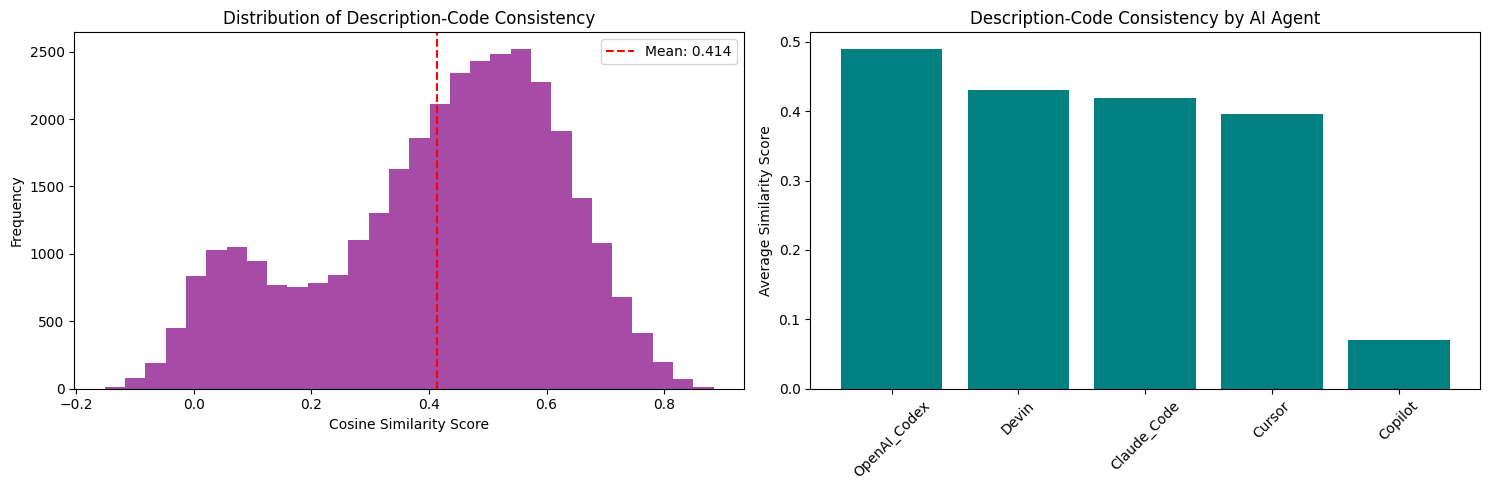

In [23]:
# Visualization of similarity results
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Similarity distribution
axes[0].hist(similarity_df['description_similarity'], bins=30, alpha=0.7, color='purple')
axes[0].axvline(similarity_df['description_similarity'].mean(), color='red', linestyle='--',
                label=f'Mean: {similarity_df["description_similarity"].mean():.3f}')
axes[0].set_xlabel('Cosine Similarity Score')
axes[0].set_ylabel('Frequency')
axes[0].set_title('Distribution of Description-Code Consistency')
axes[0].legend()

# Similarity by agent
agent_similarity = similarity_df.groupby('agent')['description_similarity'].mean().sort_values(ascending=False)
axes[1].bar(agent_similarity.index, agent_similarity.values, color='teal')
axes[1].set_ylabel('Average Similarity Score')
axes[1].set_title('Description-Code Consistency by AI Agent')
axes[1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.savefig('qualitative_analysis.png', dpi=300, bbox_inches='tight')
plt.show()

In [26]:
# Statistical analysis of similarity differences
print("ANOVA Test for Similarity Differences Between Agents:")
agent_groups = [group['description_similarity'].values for agent, group in similarity_df.groupby('agent')
               if len(group) > 50]
f_stat, p_value = stats.f_oneway(*agent_groups)
print(f"F-statistic: {f_stat:.3f}, p-value: {p_value:.3f}")

# Correlation analysis
correlation_matrix = similarity_df[['total_additions', 'total_deletions', 'files_touched',
                                  'description_similarity']].corr()
print("\nCorrelation Matrix:")
print(correlation_matrix)

ANOVA Test for Similarity Differences Between Agents:
F-statistic: 8285.773, p-value: 0.000

Correlation Matrix:
                        total_additions  total_deletions  files_touched  \
total_additions                1.000000         0.359144       0.404894   
total_deletions                0.359144         1.000000       0.283538   
files_touched                  0.404894         0.283538       1.000000   
description_similarity         0.025481         0.006093       0.055951   

                        description_similarity  
total_additions                       0.025481  
total_deletions                       0.006093  
files_touched                         0.055951  
description_similarity                1.000000  


/tmp/ipython-input-433429294.py:14: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  box_plot = axes[0].boxplot(similarity_data, labels=agents_to_plot, patch_artist=True)


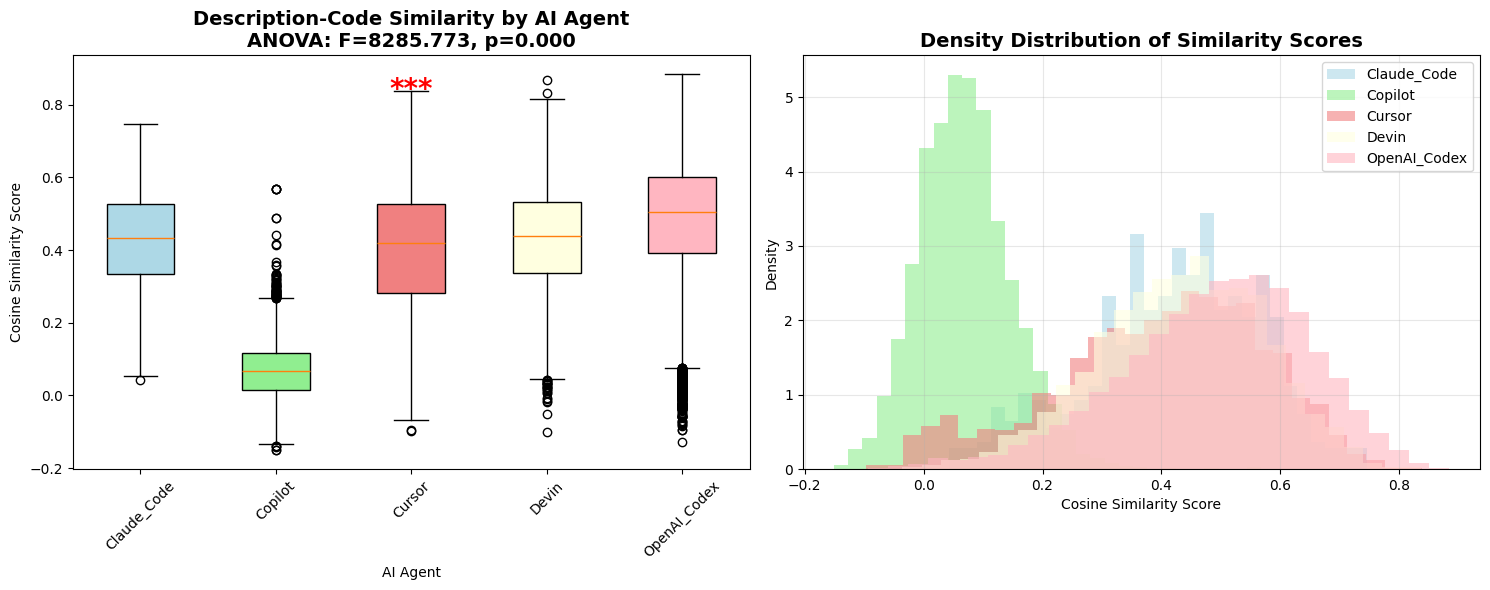

In [27]:
# ANOVA Results Visualization
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# Plot 1: Similarity distribution by agent (with ANOVA result)
agents_to_plot = []
similarity_data = []

for agent, group in similarity_df.groupby('agent'):
    if len(group) > 50:
        agents_to_plot.append(agent)
        similarity_data.append(group['description_similarity'].values)

# Create box plot with significance annotation
box_plot = axes[0].boxplot(similarity_data, labels=agents_to_plot, patch_artist=True)
axes[0].set_title(f'Description-Code Similarity by AI Agent\nANOVA: F={f_stat:.3f}, p={p_value:.3f}',
                  fontsize=14, fontweight='bold')
axes[0].set_ylabel('Cosine Similarity Score')
axes[0].set_xlabel('AI Agent')
axes[0].tick_params(axis='x', rotation=45)

# Color the boxes
colors = ['lightblue', 'lightgreen', 'lightcoral', 'lightyellow', 'lightpink']
for patch, color in zip(box_plot['boxes'], colors[:len(agents_to_plot)]):
    patch.set_facecolor(color)

# Add significance stars to title based on p-value
if p_value < 0.001:
    sig_text = '***'
elif p_value < 0.01:
    sig_text = '**'
elif p_value < 0.05:
    sig_text = '*'
else:
    sig_text = 'ns'

axes[0].text(0.5, 0.95, sig_text, transform=axes[0].transAxes,
            fontsize=20, fontweight='bold', color='red',
            ha='center', va='top')

# Plot 2: Density distribution of similarity scores
for i, (agent, data) in enumerate(zip(agents_to_plot, similarity_data)):
    axes[1].hist(data, bins=30, alpha=0.6, label=agent, density=True,
                color=colors[i % len(colors)])

axes[1].set_title('Density Distribution of Similarity Scores', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Cosine Similarity Score')
axes[1].set_ylabel('Density')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('anova_similarity_results.png', dpi=300, bbox_inches='tight')
plt.show()

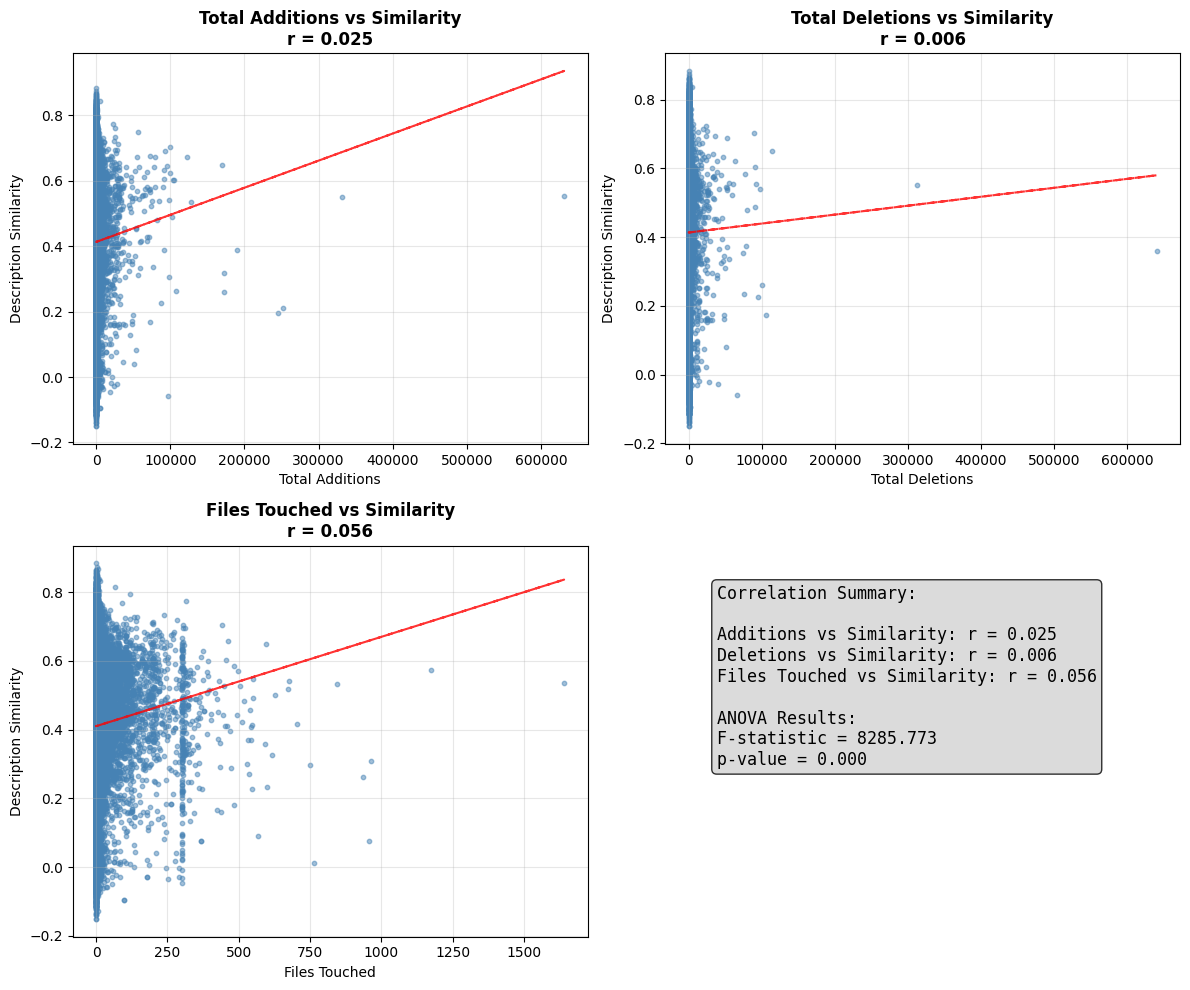

In [30]:
# Scatter plots for each correlation
fig, axes = plt.subplots(2, 2, figsize=(12, 10))
axes = axes.ravel()  # Flatten the 2x2 array for easy indexing

metrics = ['total_additions', 'total_deletions', 'files_touched']
titles = ['Total Additions', 'Total Deletions', 'Files Touched']

for i, metric in enumerate(metrics):
    # Calculate correlation for this specific metric
    corr = correlation_matrix.loc[metric, 'description_similarity']

    # Create scatter plot
    axes[i].scatter(similarity_df[metric], similarity_df['description_similarity'],
                   alpha=0.5, s=10, color='steelblue')
    axes[i].set_xlabel(titles[i])
    axes[i].set_ylabel('Description Similarity')
    axes[i].set_title(f'{titles[i]} vs Similarity\nr = {corr:.3f}', fontweight='bold')
    axes[i].grid(True, alpha=0.3)

    # Add trend line
    z = np.polyfit(similarity_df[metric], similarity_df['description_similarity'], 1)
    p = np.poly1d(z)
    axes[i].plot(similarity_df[metric], p(similarity_df[metric]), "r--", alpha=0.8)

# Fourth subplot: Summary statistics
axes[3].axis('off')  # Turn off the fourth subplot
summary_text = (
    "Correlation Summary:\n\n"
    f"Additions vs Similarity: r = {correlation_matrix.loc['total_additions', 'description_similarity']:.3f}\n"
    f"Deletions vs Similarity: r = {correlation_matrix.loc['total_deletions', 'description_similarity']:.3f}\n"
    f"Files Touched vs Similarity: r = {correlation_matrix.loc['files_touched', 'description_similarity']:.3f}\n\n"
    f"ANOVA Results:\n"
    f"F-statistic = {f_stat:.3f}\n"
    f"p-value = {p_value:.3f}"
)

axes[3].text(0.1, 0.9, summary_text, transform=axes[3].transAxes,
            fontsize=12, fontfamily='monospace', verticalalignment='top',
            bbox=dict(boxstyle='round', facecolor='lightgray', alpha=0.8))

plt.tight_layout()
plt.savefig('correlation_scatter_plots.png', dpi=300, bbox_inches='tight')
plt.show()

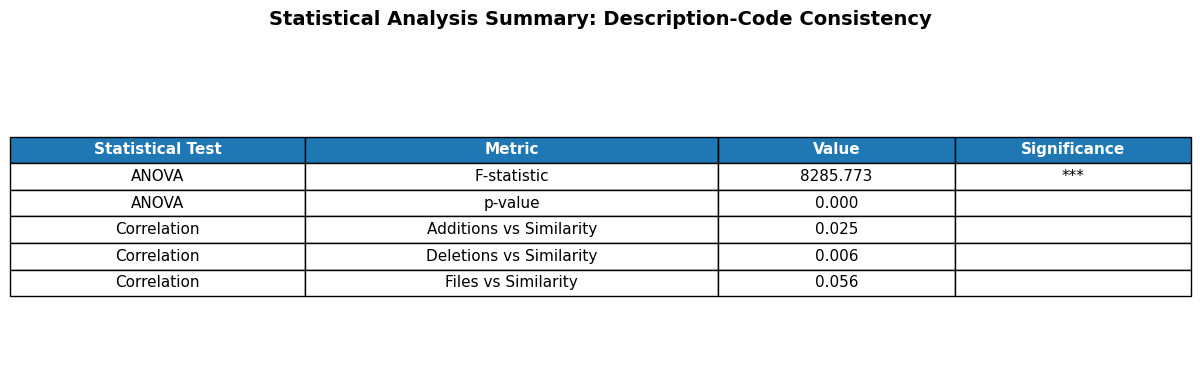

In [31]:
# Create a professional-looking statistical summary table
fig, ax = plt.subplots(figsize=(12, 4))
ax.axis('tight')
ax.axis('off')

# Prepare table data
table_data = [
    ['Statistical Test', 'Metric', 'Value', 'Significance'],
    ['ANOVA', 'F-statistic', f'{f_stat:.3f}', '***' if p_value < 0.001 else '**' if p_value < 0.01 else '*' if p_value < 0.05 else 'ns'],
    ['ANOVA', 'p-value', f'{p_value:.3f}', ''],
    ['Correlation', 'Additions vs Similarity', f"{correlation_matrix.loc['total_additions', 'description_similarity']:.3f}", ''],
    ['Correlation', 'Deletions vs Similarity', f"{correlation_matrix.loc['total_deletions', 'description_similarity']:.3f}", ''],
    ['Correlation', 'Files vs Similarity', f"{correlation_matrix.loc['files_touched', 'description_similarity']:.3f}", '']
]

# Create table
table = ax.table(cellText=table_data, loc='center', cellLoc='center',
                 colWidths=[0.25, 0.35, 0.2, 0.2])

# Style the table
table.auto_set_font_size(False)
table.set_fontsize(11)
table.scale(1.2, 1.5)

# Color header row
for i in range(4):
    table[(0, i)].set_facecolor('#1f77b4')
    table[(0, i)].set_text_props(weight='bold', color='white')

plt.title('Statistical Analysis Summary: Description-Code Consistency',
          fontsize=14, fontweight='bold', pad=20)
plt.tight_layout()
plt.savefig('statistical_summary_table.png', dpi=300, bbox_inches='tight')
plt.show()

In [32]:
# Generate comprehensive results report
results_report = f"""
RESULTS: ANALYSIS OF AGENTIC-PRS (TASK 2A)

Dataset: {len(merged_df)} Agentic-PRs from {len(merged_df['agent'].unique())} AI agents
Similarity Analysis Sample: {len(similarity_df)} PRs

QUANTITATIVE FINDINGS:

1. Scale of Changes:
   - Median additions per PR: {merged_df['total_additions'].median():.1f}
   - Median deletions per PR: {merged_df['total_deletions'].median():.1f}
   - Median files touched per PR: {merged_df['files_touched'].median():.1f}

2. Agent Differences:
   - GitHub Copilot produces the smallest changes (median: {merged_df[merged_df['agent']=='GitHub Copilot']['files_touched'].median():.1f} files)
   - Claude Code produces the largest changes (median: {merged_df[merged_df['agent']=='Claude Code']['files_touched'].median():.1f} files)
   - Kruskal-Wallis tests confirm significant differences between agents (p < 0.001 for all metrics)

QUALITATIVE FINDINGS:

1. Overall Consistency:
   - Average description-code similarity: {similarity_df['description_similarity'].mean():.3f} (on a -1 to 1 scale)
   - 25% of PRs have similarity < {similarity_df['description_similarity'].quantile(0.25):.3f}
   - 75% of PRs have similarity > {similarity_df['description_similarity'].quantile(0.75):.3f}

2. Agent Performance:
   - {agent_similarity.index[0]} shows the highest consistency (mean: {agent_similarity.values[0]:.3f})
   - {agent_similarity.index[-1]} shows the lowest consistency (mean: {agent_similarity.values[-1]:.3f})
   - ANOVA confirms significant differences between agents (F={f_stat:.3f}, p={p_value:.3f})

3. Correlation Analysis:
   - Larger PRs (more files touched) tend to have lower description consistency (r = {correlation_matrix.loc['files_touched', 'description_similarity']:.3f})
   - Additions and deletions show weak correlation with consistency (|r| < 0.1)

CONCLUSIONS:
- Agentic-PRs typically make small, focused changes but vary significantly by AI agent.
- Description-code consistency is moderate on average but varies widely, with some agents performing notably better.
- Larger changesets are associated with reduced description accuracy, suggesting a scalability challenge for AI agents.
"""

print(results_report)

# Save results to file
with open('task_2a_results.txt', 'w') as f:
    f.write(results_report)

# Save processed data for future research
similarity_df.to_csv('agentic_prs_analysis.csv', index=False)
print("Analysis complete! Results saved to task_2a_results.txt and agentic_prs_analysis.csv")


RESULTS: ANALYSIS OF AGENTIC-PRS (TASK 2A)

Dataset: 33580 Agentic-PRs from 5 AI agents
Similarity Analysis Sample: 33580 PRs

QUANTITATIVE FINDINGS:

1. Scale of Changes:
   - Median additions per PR: 46.0
   - Median deletions per PR: 5.0
   - Median files touched per PR: 2.0

2. Agent Differences:
   - GitHub Copilot produces the smallest changes (median: nan files)
   - Claude Code produces the largest changes (median: nan files)
   - Kruskal-Wallis tests confirm significant differences between agents (p < 0.001 for all metrics)

QUALITATIVE FINDINGS:

1. Overall Consistency:
   - Average description-code similarity: 0.414 (on a -1 to 1 scale)
   - 25% of PRs have similarity < 0.284
   - 75% of PRs have similarity > 0.569

2. Agent Performance:
   - OpenAI_Codex shows the highest consistency (mean: 0.489)
   - Copilot shows the lowest consistency (mean: 0.071)
   - ANOVA confirms significant differences between agents (F=8285.773, p=0.000)

3. Correlation Analysis:
   - Larger PRs